**Santa's Workshop Kaggle Competition**
This competition is a scheduling optimization challenge where you have two major factors to consider:
1. The preferred day for a family to visit has costs associated to it. Where the costs are as follows:
    * choice_0: no consolation gifts
    * choice_1: one 50 gift card to Santa's Gift Shop
    * choice_2: one 50 gift card, and 25% off Santa's Buffet (value 9) for each family member
    * choice_3: one 100 gift card, and 25% off Santa's Buffet (value 9) for each family member
    * choice_4: one 200 gift card, and 25% off Santa's Buffet (value 9) for each family member
    * choice_5: one 200 gift card, and 50% off Santa's Buffet (value 18) for each family member
    * choice_6: one 300 gift card, and 50% off Santa's Buffet (value 18) for each family member
    * choice_7: one 300 gift card, and free Santa's Buffet (value 36) for each family member
    * choice_8: one 400 gift card, and free Santa's Buffet (value 36) for each family member
    * choice_9: one 500 gift card, and free Santa's Buffet (value 36) for each family member, and 50% off North Pole Helicopter Ride tickets (value 199) for each family member
    * otherwise: one 500 gift card, and free Santa's Buffet (value 36) for each family member, and free North Pole Helicopter Ride tickets (value 398) for each family member
2. The daily occupancy from a previous day affects the next day's costs. By the following equation:
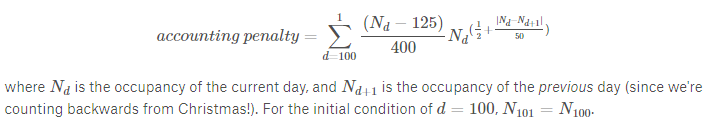


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

fpath = '/kaggle/input/santa-workshop-tour-2019/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = '/kaggle/input/santa-workshop-tour-2019/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [ ]:
family_size_dict = data[['n_people']].to_dict()['n_people']
m,_ = data.shape 

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].T.to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

In [ ]:
data.head()

**Each family has 10 main choices, which each choice is a day in the 100 day period they want to visit Santa, the higher tiers of preference for a certain day, the more we pay, so we are trying to optimize the most prefered choice we can give each family as to minimize costs. **

In [ ]:
plt.figure(figsize=(16,9))
sns.countplot(data['n_people'])

**There are certain choices that we need to make that take into account the number of people, this will be further explored later**

In [ ]:
plt.figure(figsize=(16,9))
sns.distplot(data['choice_0'],bins=100,kde=False)
plt.title('Preferred Choice of each Family')

In [ ]:
plt.figure(figsize=(16,9))
sns.distplot(data['choice_9'],bins=100,kde=False)
plt.title('Least Preferred Choice for each Family')

**All choices seem to follow the same distribution, the takeaways are:**
*     Friday/Saturday/Sunday are busier overall
*     Weekdays, even the ones near christmas, have lower preference overall.

In [ ]:
def weekday(days):
    weekday = []
    for day in days:
        if day%7==2:
            weekday.append('Monday')
        elif day%7==1:
            weekday.append('Tuesday')
        elif day%7==0:
            weekday.append('Wednesday')
        elif day%7==6:
            weekday.append('Thursday')
        elif day%7==5:
            weekday.append('Friday')
        elif day%7==4:
            weekday.append('Saturday')
        else:
            weekday.append('Sunday')
    return weekday
weekday_list = [weekday(data[cols].values[i][:].tolist()) for i in range(5000)]
weekday_list = pd.DataFrame(weekday_list,columns = ['weekday_'+cols[i] for i in range(10)])
weekday_list

In [ ]:
plt.figure(figsize=(16,9))
sns.countplot(weekday_list['weekday_choice_0'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

In [ ]:
plt.figure(figsize=(16,9))
sns.countplot(weekday_list['weekday_choice_9'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

**You probably gain a lot from prioritizing choices in the weekdays Mon-Thu since most people's other choices are in the weekends**

Tuesday seems higher than it is because it is also christmas eve, which is the day with higher preference overall.

If you initialize your guess by getting the minimum ammount of people in each weekday with the minimum possible cost, the weekends should be easy enough to optimize.

In [ ]:
#lets set a difficulty score per choice, 0 is weekdays, 1 is weekends, 2 is christmas eve
def difficulty(days):
    dif = []
    for day in days:
        wd = weekday([day])
        if day == 1 or day == 2 or day == 3:
            dif.append(1)
        elif wd[0]=='Monday' or wd[0]=='Tuesday' or wd[0]=='Wednesday' or wd[0]=='Thursday':
            dif.append(0)
        else:
            dif.append(1)
    return dif

dif_list = [difficulty(data[cols].values[i][:].tolist()) for i in range(5000)]
dif_list = pd.DataFrame(dif_list,columns = ['difficulty_'+cols[i] for i in range(10)])
dif_sum = pd.DataFrame(np.sum(dif_list,axis=1),columns=['dif_sum'])
#data = pd.concat([data,dif_sum],axis=1)
plt.figure(figsize=(16,9))
sns.countplot(dif_sum['dif_sum'])
plt.title("Number of difficult days per family")
print("The mean number of difficult days per family is: {}".format(np.mean(dif_sum['dif_sum'])))
print("Standard deviation of difficult days is: {}".format(np.std(dif_sum['dif_sum'])))

**This is a feature made to visualize how much families prefer weekends and days near christmas over weekdays.**
We show here that for 10 choices, on average, 7 of them are either near christmas or on the weekends (fridays, saturdays and sundays).
The choice between weekends and weekdays seem to follow a normal distribution with a mean of 7.2 and standard deviation of 1.4.

In [ ]:
family_size = list(range(2,9))
cost_per_family_size = np.zeros((11,len(family_size)))
def choice_cost(n,choice):
    if choice == 0:
        return 0
    elif choice == 1:
        return 50
    elif choice == 2:
        return 50 + 9 * n
    elif choice == 3:
        return 100 + 9 * n
    elif choice == 4:
        return 200 + 9 * n
    elif choice == 5:
        return 200 + 18 * n
    elif choice == 6:
        return 300 + 18 * n
    elif choice == 7:
        return 300 + 36 * n
    elif choice == 8:
        return 400 + 36 * n
    elif choice == 9:
        return 500 + 36 * n + 199 * n
    else:
        return 500 + 36 * n + 398 * n
j = 0
for n in family_size:  
    for i in range(11):
        cost_per_family_size[i,j]=choice_cost(n,i)
    j+=1

cost_per_family_size = pd.DataFrame(cost_per_family_size.T,index = [str(x)+'_people' for x in range(2,9)],columns = ['choice_'+str(x) for x in range(11)])
cost_per_family_size['n_people']=list(range(2,9))
cost_per_family_size

In [ ]:
plt.figure(figsize=(16,9))
for i in range(11):
    sns.lineplot(data=cost_per_family_size,x='n_people',y='choice_'+str(i))

We should definitely avoid choices 9 and no choices since they grow really quickly with family size.

In [ ]:
plt.figure(figsize=(16,9))
for i in range(2,9):
    sns.lineplot(data=cost_per_family_size,x='n_people',y='choice_'+str(i))

No choice overlaps family size, indicating that no matter the family size it's always better to prioritize choice over family size, and within the same choice category, prioritise family size.

In [ ]:
sorted_families = []
daily_occupancy={i:0 for i in range(1,101)}
answer = np.zeros((m,3))
for j in range(4):
    for i in range(m):
        if difficulty(data.loc[i][['choice_'+str(j)]])==[0] and i not in sorted_families and daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+data.loc[i][['n_people']][0]<300:
            sorted_families.append(i)
            answer[i,0]=i
            answer[i,1]=data.loc[i][['choice_'+str(j)]]
            answer[i,2]=j
            daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]

In [ ]:
def daily_plot(answer):
    def get_daily_occupancy(answer):
        daily_occupancy={i:0 for i in range(0,101)}
        for i in range(m):
            daily_occupancy[int(answer[i,1])]+=data.loc[i]['n_people']
        return daily_occupancy
    daily_occupancy = get_daily_occupancy(answer)
    plt.figure(figsize=(12,7))
    fig = sns.lineplot(x=list(range(1,101)),y=[daily_occupancy[i] for i in range(1,101)])
    ax = plt.axes()
    x = np.linspace(0, 100, 100)
    y= np.linspace(125,125,100)
    ax.plot(x, y,color='green');
    x = np.linspace(0, 100, 100)
    y= np.linspace(300,300,100)
    ax.plot(x, y,color='red')
daily_plot(answer)

After a simple greedy initialization of the four most preferred choices we have the graph above, indicating that just simply favouring those four main choices are not enough to comply with the minimum of 125 people on weekdays. Let's try now to correct the few points which are below the green line.

In [ ]:
for j in range(4,8):
    for i in range(m):
        if difficulty(data.loc[i][['choice_'+str(j)]])==[0] and i not in sorted_families and daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]<125:
            sorted_families.append(i)
            answer[i,0]=i
            answer[i,1]=data.loc[i][['choice_'+str(j)]]
            answer[i,2]=j
            daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
daily_plot(answer)

Every weekday is now initialized between 125 and 300 persons per day, now let's try and do the same with the weekends.

In [ ]:
for j in range(4):
    for i in range(m):
        if (difficulty(data.loc[i][['choice_'+str(j)]])==[1] or difficulty(data.loc[i][['choice_'+str(j)]])==[2]) and i not in sorted_families and daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+data.loc[i][['n_people']][0]<300:
            sorted_families.append(i)
            answer[i,0]=i
            answer[i,1]=data.loc[i][['choice_'+str(j)]]
            answer[i,2]=j
            daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
daily_plot(answer)

After weekend choice initialization, there's only 3 points below 125 participants, let's run a quick unoptimized swap just to get a baseline.
We need to start thinking about swaps because all families are sorted.

In [ ]:
del sorted_families
for k,v in daily_occupancy.items():
    if v<125:
        for j in range(4):
            for i in range(m):
                if daily_occupancy[data.loc[i][['choice_'+str(int(answer[i,2]))]][0]]-data.loc[i][['n_people']][0]>=125 and data.loc[i][['choice_'+str(j)]][0]==k and daily_occupancy[k]<=125:
                    answer[i,0]=i
                    answer[i,1]=data.loc[i][['choice_'+str(j)]]
                    answer[i,2]=j
                    daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
daily_plot(answer)

Now every family is initialized by their preferred choice, going for weekdays first.

We can see that the value for each days attendance heavily fluctuates, which is really bad for the accounting cost, let's check that now.

In [ ]:
def accounting(today,yesterday):
    return max(0, (today-125.0) / 400.0 * today**(0.5 + abs(today-yesterday) / 50.0))
acc_matrix = np.zeros((301,301))
for i, x in enumerate(range(1,300+1)):
    for j, y in enumerate(range(1,300+1)):
        acc_matrix[i,j] = np.log10(accounting(x,y))
        
plt.figure(figsize=(10,10))
plt.imshow(np.clip(acc_matrix, 0, 4000))
plt.xlim(125,300)
plt.ylim(125,300)
plt.title('log10(Accounting Cost)')
plt.colorbar()

Besides giving everyone their preferred choice, the above graph indicates that accounting costs rise exponentially with the difference between two consecutive days attendance.

In [ ]:
'''Original Code from https://www.kaggle.com/nickel/santa-s-2019-fast-pythonic-cost-23-s thanks to Rafael Crescenzi'''
import numpy as np
import pandas as pd
from numba import njit, prange

family_size = data.n_people.values.astype(np.int8)

penalties = np.asarray([
    [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ] for n in range(family_size.max() + 1)
])
family_cost_matrix = np.concatenate(data.n_people.apply(lambda n: np.repeat(penalties[n, 10], 100).reshape(1, 100)))
for fam in data.index:
    for choice_order, day in enumerate(data.loc[fam].drop("n_people")):
        family_cost_matrix[fam, day - 1] = penalties[data.loc[fam, "n_people"], choice_order]
accounting_cost_matrix = np.zeros((500, 500))
for n in range(accounting_cost_matrix.shape[0]):
    for diff in range(accounting_cost_matrix.shape[1]):
        accounting_cost_matrix[n, diff] = max(0, (n - 125.0) / 400.0 * n**(0.5 + diff / 50.0))

In [ ]:
@njit(fastmath=True)
def cost_function(prediction, family_size, family_cost_matrix, accounting_cost_matrix):
    N_DAYS = family_cost_matrix.shape[1]
    MAX_OCCUPANCY = 300
    MIN_OCCUPANCY = 125
    penalty = 0
    daily_occupancy = np.zeros(N_DAYS + 1, dtype=np.int16)
    for i, (pred, n) in enumerate(zip(prediction, family_size)):
        daily_occupancy[pred - 1] += n
        penalty += family_cost_matrix[i, pred - 1]

    accounting_cost = 0
    n_low = 0
    n_high = 0
    daily_occupancy[-1] = daily_occupancy[-2]
    for day in range(N_DAYS):
        n_next = daily_occupancy[day + 1]
        n = daily_occupancy[day]
        n_high += (n > MAX_OCCUPANCY) 
        n_low += (n < MIN_OCCUPANCY)
        diff = abs(n - n_next)
        accounting_cost += accounting_cost_matrix[n, diff]

    return np.asarray([penalty, accounting_cost, n_low, n_high])

In [ ]:
def get_cost_consolidated(prediction): 
    fc, ac, l, h = cost_function(prediction, family_size, family_cost_matrix, accounting_cost_matrix)
    return (fc + ac) + (l + h) * 10000000
print(get_cost_consolidated(answer[:,1].astype(np.int8)))

We see now that even when trying to optimize based on choice is not enough even for a modest solution, we need to also take into account the previous days attendance.

Let's try and redo the sorting taking into account a simple fitting function. We need to know the maximum cost for day 100 as it is the only day which is independant from the others.

In [ ]:
acc_day100 = np.zeros((300,1))
for i, x in enumerate(range(1,300+1)):
    acc_day100[i] = accounting(x,x)
plt.figure(figsize=(10,10))
sns.lineplot(x=[i for i in range(1,301)],y=acc_day100[:,0])
plt.title('Accounting Cost for day 100')
plt.xlim(125,300)

We can probably initiate day 100 to any attendance since the maximum accounting cost is a little over 7. 

We then could solve the next day establishing a maximum difference from the previous days.

We previously had a for loop over choice, let's try now doing a for loop for each day in sequence, and a while loop inside for each choice up until this difference criteria is met.

In [ ]:
n = 0
for i in range(m):
    n+=data.loc[i][['n_people']][0]
print(str(n)+" total people to visit Santa")

In [ ]:
sorted_families = {i:0 for i in range(m)}
daily_occupancy={i:0 for i in range(1,101)}
answer = np.zeros((m,2))
prev_day = 125
diff = 1
factor = 7
for day in days:
    for choice in range(4):
        for i in range(m):
            if data.loc[i][['choice_'+str(choice)]][0]==day and sorted_families[i]==0:
                if daily_occupancy[day]+data.loc[i][['n_people']][0]<=300:
                    if daily_occupancy[day]-prev_day<diff and daily_occupancy[day]-prev_day<diff*factor:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=day
                        daily_occupancy[day]+=data.loc[i][['n_people']][0]
                    elif daily_occupancy[day]<125:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=day
                        daily_occupancy[day]+=data.loc[i][['n_people']][0]
    prev_day = daily_occupancy[day]
daily_plot(answer)

We need to make sure that the transition between days is as smooth as possible.

Let's do a second run looping over less preferable choices to try and get every family sorted.

In [ ]:
diff_normalizer = 1
diff = 2
count=sum([sorted_families[i]==1 for i in range(m)])
while count<m:
    daily_occupancy[101]=daily_occupancy[100]
    for j in range(9):
        for i in range(m):
            daily_occupancy[101]=daily_occupancy[100]
            if sorted_families[i]==0:
                if daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+data.loc[i][['n_people']][0]<=300:
                    if abs(daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]-daily_occupancy[data.loc[i][['choice_'+str(j)]][0]+1])<diff_normalizer*diff:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=data.loc[i][['choice_'+str(j)]]
                        daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
                    elif daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]<125:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=data.loc[i][['choice_'+str(j)]]
                        daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
    count=sum([sorted_families[i]==1 for i in range(m)])
    print("{}# iteration -> {} families sorted with a combined cost of {}".format(diff_normalizer,count,get_cost_consolidated(answer[:,1].astype(np.int8))))
    diff_normalizer+=1
daily_plot(answer)

In [ ]:
def optimize(answer,n_iter=100,verbose=5,print_ = False,rd_seed=23):
    import random
    try:
        new_answer=answer[:,1].copy()
        best_score = get_cost_consolidated(new_answer[:].astype(np.int8))
    except IndexError:
        new_answer=answer.copy()
        best_score = get_cost_consolidated(new_answer[:].astype(np.int8))
    if print_:
        print('Start score: {}'.format(best_score))
    start_score = best_score
    random.seed(rd_seed)
    family_list = list(range(m))
    for n in range(n_iter):
        random.shuffle(days)
        random.shuffle(family_list)
        for day in days:
            for i in family_list:
                aux = new_answer[i]
                new_answer[i]=day
                new_score = get_cost_consolidated(new_answer[:].astype(np.int8))
                if new_score<=best_score:
                    try:
                        answer[i,1]=day
                    except:
                        answer[i]=day
                    best_score = new_score
                else:
                    new_answer[i]=aux
        if not best_score == start_score:
            start_score = best_score
        else:
            print("{}# early stopping best score: {}".format(n+1,best_score))
            break
        if (n+1)%verbose==0 and print_:
            print("{}# best score: {}".format(n+1,best_score))
    return answer

In [ ]:
def find_seed(answer):
    start_answer = answer.copy()
    best_score = get_cost_consolidated(answer[:,1].astype(np.int8))
    best = 0
    for i in range(1000):
        new_answer = optimize(start_answer[:,1].copy(),n_iter=2000,verbose=5,print_=False,rd_seed = i)
        new_score = get_cost_consolidated(new_answer[:].astype(np.int8))
        if new_score<best_score:
            best_score = new_score
            best = i
            print(best)
    return best

In [ ]:
answer = optimize(answer,n_iter=2000,verbose=5,print_=True,rd_seed=23)

In [ ]:
daily_plot(answer)
get_cost_consolidated(answer[:,1].astype(np.int8))

In [ ]:
'''Original code from : https://www.kaggle.com/xhlulu/santa-s-2019-stochastic-product-search'''
from itertools import product
from tqdm.notebook import tqdm
choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values
def stochastic_product_search(top_k, fam_size, original, choice_matrix, 
                              disable_tqdm=False, verbose=10000,
                              n_iter=500, random_state=2019):
    """
    original (np.array): The original day assignments.
    
    At every iterations, randomly sample fam_size families. Then, given their top_k
    choices, compute the Cartesian product of the families' choices, and compute the
    score for each of those top_k^fam_size products.
    """
    
    best = original.copy()
    best_score = get_cost_consolidated(best)
    
    np.random.seed(random_state)

    for i in tqdm(range(n_iter), disable=disable_tqdm):
        fam_indices = np.random.choice(range(choice_matrix.shape[0]), size=fam_size)
        changes = np.array(list(product(*choice_matrix[fam_indices, :top_k].tolist())))

        for change in changes:
            new = best.copy()
            new[fam_indices] = change

            new_score = get_cost_consolidated(new)

            if new_score < best_score:
                best_score = new_score
                best = new
        
        if new_score < best_score:
            best_score = new_score
            best = new
    
        if verbose and i % verbose == 0:
            print(f"Iteration #{i}: Best score is {best_score:.2f}")
    
    print(f"Final best score is {best_score:.2f}")
    return best

final = stochastic_product_search(
        top_k=4,
        fam_size=3, 
        original=answer[:,1].astype(np.int8),
        choice_matrix = choice_matrix,
        disable_tqdm = False,
        n_iter=1000000,
        verbose=50000,
        )

In [ ]:
aux = np.zeros((m,2))
aux[:,1]=final
final = stochastic_product_search(
        top_k=4,
        fam_size=5, 
        original=final.astype(np.int8),
        choice_matrix = choice_matrix,
        disable_tqdm = False,
        n_iter=250000,
        verbose=5000,
        )
daily_plot(aux)

More to come!
Please leave a comment as i am learning.

Next steps are:
-Implement the stochastic sorting algorithm

If you liked the insights please upvote :)

In [ ]:
final = stochastic_product_search(
        top_k=3,
        fam_size=8, 
        original=final.astype(np.int8),
        choice_matrix = choice_matrix,
        disable_tqdm = False,
        n_iter=40000,
        verbose=5000,
        )
aux = np.zeros((m,2))
aux[:,1]=final
daily_plot(aux)

In [ ]:
prediction = pd.Series(final.astype(np.int8), name="assigned_day")
prediction.index.name = "family_id"
prediction.to_csv("submission.csv", index=True, header=True)